In [46]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras

\begin{align}
L_2(A,B) &= \sqrt{\sum_{i=1}^{n}(A_i - B_i)^2} \\
\|A\| &= \sqrt{\sum_{i=1}^{n}(A_i^2)}\\
A \cdot B &= \sum_{i=1}^{n}(A_iB_i) = \|A\|\|B\|\cos(\theta) \\
\end{align}

In [47]:
telcom = pd.read_csv('https://raw.githubusercontent.com/bensadeghi/pyspark-churn-prediction/master/data/churn-bigml-80.csv')
telcom_test = pd.read_csv('https://raw.githubusercontent.com/bensadeghi/pyspark-churn-prediction/master/data/churn-bigml-20.csv')
telcom['International plan'] = telcom['International plan'].map({'Yes':1, 'No':0})
telcom['Voice mail plan'] = telcom['Voice mail plan'].map({'Yes':1, 'No':0})
telcom_test['International plan'] = telcom_test['International plan'].map({'Yes':1, 'No':0})
telcom_test['Voice mail plan'] = telcom_test['Voice mail plan'].map({'Yes':1, 'No':0})

telcom.columns = telcom.columns.str.replace(' ', '_')
telcom_test.columns = telcom_test.columns.str.replace(' ', '_')

display(telcom.columns)
display(telcom.head())

Index(['State', 'Account_length', 'Area_code', 'International_plan',
       'Voice_mail_plan', 'Number_vmail_messages', 'Total_day_minutes',
       'Total_day_calls', 'Total_day_charge', 'Total_eve_minutes',
       'Total_eve_calls', 'Total_eve_charge', 'Total_night_minutes',
       'Total_night_calls', 'Total_night_charge', 'Total_intl_minutes',
       'Total_intl_calls', 'Total_intl_charge', 'Customer_service_calls',
       'Churn'],
      dtype='object')

,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


,International_plan,Voice_mail_plan,Total_day_minutes,Total_eve_minutes,Total_night_minutes,Total_intl_minutes,Customer_service_calls,Account_length
0,-0.335627,1.623613,1.579373,-0.058608,0.857243,-0.085004,-0.429092,0.692033
1,-0.335627,1.623613,-0.329856,-0.095898,1.048261,1.241946,-0.429092,0.161248
2,-0.335627,-0.615679,1.179081,-1.554147,-0.759525,0.703993,-1.191731,0.919513
3,2.978380,-0.615679,2.212094,-2.717999,-0.084067,-1.304364,0.333547,-0.420089
4,2.978380,-0.615679,-0.235778,-1.022269,-0.280994,-0.049141,1.096187,-0.647569
...,...,...,...,...,...,...,...,...
2661,-0.335627,-0.615679,-0.826071,-0.209732,0.398403,0.560539,0.333547,-0.546467
2662,-0.335627,1.623613,-0.429468,0.296632,1.534670,-0.120868,0.333547,2.309667
2663,-0.335627,-0.615679,0.952187,-0.922174,-0.194346,-0.228458,1.096187,-0.824498
2664,-0.335627,-0.615679,0.024320,1.735254,-0.182530,1.385400,0.333547,-1.835518


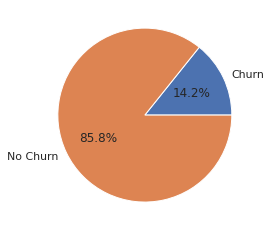

In [48]:
# Choose a subset of columns as features.
features = ['International_plan', 'Voice_mail_plan',
           'Total_day_minutes', 'Total_eve_minutes', 'Total_night_minutes', 
           'Total_intl_minutes', 'Customer_service_calls', 'Account_length']

X_train = telcom[features]
X_test = telcom_test[features]
Y_train = telcom['Churn']
Y_test = telcom_test['Churn']

feature_means = X_train.mean()
feature_stds = X_train.std()
X_train = (X_train - feature_means) / feature_stds
X_test = (X_test - feature_means) / feature_stds

# Verify the normalized data looks reasonable.
display(X_train)
plt.pie([sum(Y_test)/len(Y_test), 1-sum(Y_test)/len(Y_test)],
        labels=['Churn', 'No Churn'], autopct='%.1f%%')
plt.show()

In [49]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
knn = KNeighborsClassifier(n_neighbors=13, algorithm='brute')
knn.fit(X_train, Y_train)
preds = knn.predict_proba(X_test)[:,1]
print('Accuracy: %1.4f' %accuracy_score(Y_test, preds>.5))
print('AP: %1.4f' %average_precision_score(Y_test, preds))

Accuracy: 0.9130
AP: 0.7321


In [50]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0, penalty='none')
lr.fit(X_train, Y_train)
preds = lr.predict_proba(X_test)[:,1]
print('Accuracy: %1.4f' %accuracy_score(Y_test, preds>0.5))
print('AP: %1.4f' %average_precision_score(Y_test, preds))

Accuracy: 0.8531
AP: 0.4334


Accuracy: 0.8816
Train AP: 0.5674
Test AP:  0.5558


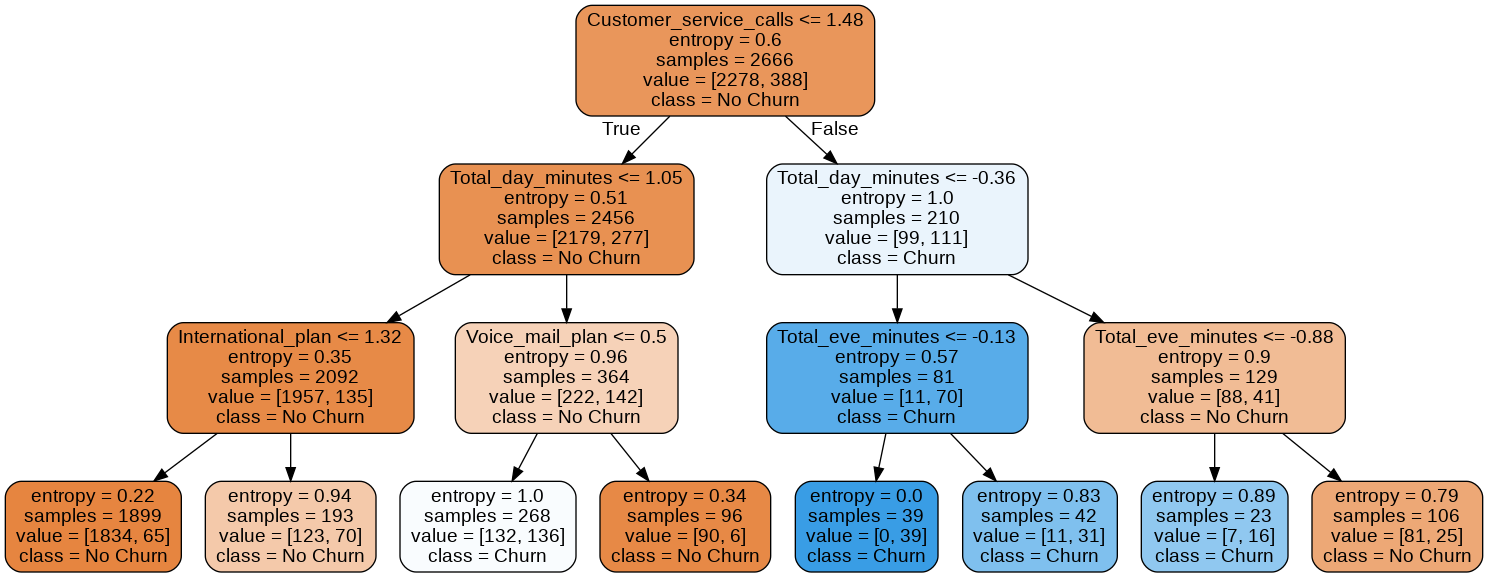

In [51]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
dt.fit(X_train, Y_train)
preds = dt.predict_proba(X_test)[:,1]
train_preds = dt.predict_proba(X_train)[:,1]
print('Accuracy: %1.4f' %accuracy_score(Y_test, preds>0.5))
print('Train AP: %1.4f' %average_precision_score(Y_train, train_preds))
print('Test AP:  %1.4f' %average_precision_score(Y_test, preds,))
#display(dict(zip(features, dt.feature_importances_)))

from sklearn.tree import export_graphviz
from sklearn import tree
from graphviz import Source
from IPython.display import Image

graph = Source(tree.export_graphviz(dt, out_file=None,
                                    rounded=True, proportion=False,
                                    feature_names=features, 
                                    precision=2,
                                    class_names=['No Churn', 'Churn'],
                                    filled=True))

png_bytes = graph.pipe(format='png')
with open('dt.png','wb') as f:
  f.write(png_bytes)
Image(png_bytes)

In [52]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=None, max_samples=0.8,
                            criterion='entropy', n_estimators=100,
                            random_state=0)
rf.fit(X_train, Y_train)
preds = rf.predict_proba(X_test)[:,1]
train_preds = rf.predict(X_train)
print('Accuracy: %1.4f' %accuracy_score(Y_test, preds>.5))
print('AP: %1.4f' %average_precision_score(Y_train, train_preds))
print('AP: %1.4f' %average_precision_score(Y_test, preds))

Accuracy: 0.9505
AP: 0.9802
AP: 0.8514


In [53]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(max_depth=7, subsample=0.7, random_state=0)
gb.fit(X_train, Y_train)
preds = gb.predict_proba(X_test)[:,1]
print('Accuracy: %1.4f' %accuracy_score(Y_test, preds>.5))
print('AP: %1.4f' %average_precision_score(Y_test, preds))

Accuracy: 0.9505
AP: 0.8590


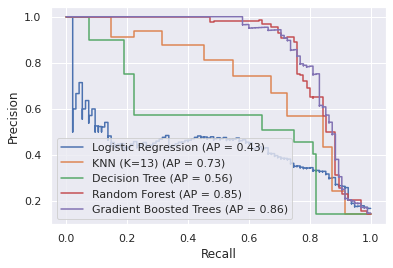

In [54]:
plot_precision_recall_curve(lr, X_test, Y_test, ax = plt.gca(), name='Logistic Regression')
plot_precision_recall_curve(knn, X_test, Y_test, ax = plt.gca(), name='KNN (K=13)')
plot_precision_recall_curve(dt, X_test, Y_test, ax = plt.gca(), name='Decision Tree')
plot_precision_recall_curve(rf, X_test, Y_test, ax = plt.gca(), name='Random Forest')
plot_precision_recall_curve(gb, X_test, Y_test, ax = plt.gca(), name='Gradient Boosted Trees')
plt.show()

In [55]:
def entropy(p):
  sum = 0
  for i in p:
    sum -= i*np.log2(i+1e-37)
    #print(sum)
  return sum

print(entropy([0.5,.5]))
print(entropy([5/8, 3/8]))
print(entropy([0,1]))
print(.4*entropy([15/40,25/40]) + .6*entropy([35/60,25/60]))

1.0
0.9544340029249649
0.0
0.9696948551606777


In [56]:
#!pip install tensorflow_decision_forests

import tensorflow_decision_forests as tfdf

features = ['International_plan', 'Voice_mail_plan',
           'Total_day_minutes', 'Total_eve_minutes', 'Total_night_minutes', 
           'Total_intl_minutes', 'Customer_service_calls', 'Account_length',
            'Churn']
X_train_tf = tfdf.keras.pd_dataframe_to_tf_dataset(telcom[features], label='Churn')
X_test_tf = tfdf.keras.pd_dataframe_to_tf_dataset(telcom_test[features], label='Churn')
model = tfdf.keras.RandomForestModel()
model.fit(X_train_tf)

model.compile(metrics=['accuracy', tf.keras.metrics.AUC(curve='PR')])
print(model.evaluate(X_test_tf))

tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

11/11 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9460 - auc_7: 0.8577
[0.0, 0.9460269808769226, 0.857689380645752]
